In [242]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy
import montecarlo_localization as mcl
%load_ext autoreload
%autoreload 2
%matplotlib inline
plt.style.use('ggplot')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Development Notes

## Method for extracting particles by weight

In [70]:
a = np.array([p for p in range(10)])
a

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [71]:
b = a / a.sum()
b

array([ 0.        ,  0.02222222,  0.04444444,  0.06666667,  0.08888889,
        0.11111111,  0.13333333,  0.15555556,  0.17777778,  0.2       ])

In [72]:
choices = np.random.multinomial(len(a), b)
choices

array([0, 0, 0, 1, 2, 1, 0, 3, 2, 1])

In [92]:
new_particle_list = []
for idx, count in enumerate(choices):
    while count > 0:
        new_particle_list.append(copy.copy(a[idx]))
        count -= 1
new_particle_list

[3, 4, 4, 5, 7, 7, 7, 8, 8, 9]

above implemented in `montecarlo_localization.mcl_update()`

# Unit Tests:

## Load and plot Wean Hall map

Test implementation

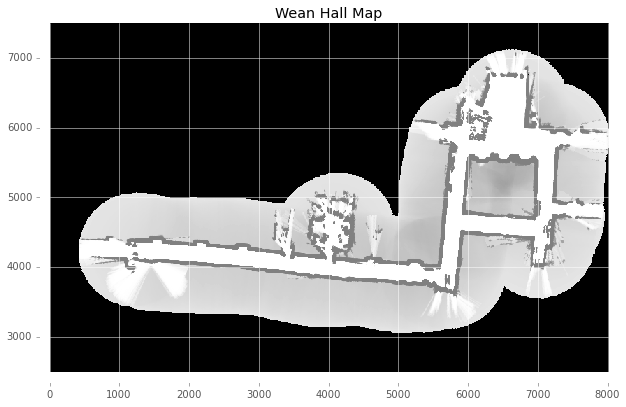

In [75]:
global_map = mcl.occupancy_map('data/map/wean.dat.gz')
mcl.draw_map_state(global_map, rotate=True)

## mcl.sample_list_by_weight()

In [76]:
toy_list = [l for l in 'abcd']
weights  = [10,5,1,0.1]

sample_list = [mcl.sample_list_by_weight(toy_list, weights) 
               for _ in range(100)]
print(sample_list[:10])
df = pd.DataFrame(sample_list)
print("\nValue Counts in first location:")
print(df[0].value_counts())

[['a', 'a', 'b', 'b'], ['a', 'a', 'a', 'a'], ['a', 'b', 'b', 'a'], ['b', 'a', 'a', 'a'], ['b', 'a', 'a', 'a'], ['b', 'a', 'a', 'b'], ['c', 'b', 'a', 'a'], ['a', 'a', 'b', 'a'], ['a', 'b', 'b', 'b'], ['a', 'a', 'b', 'a']]

Value Counts in first location:
a    55
b    36
c     8
d     1
Name: 0, dtype: int64


## mcl.transform_pose()

In [142]:
# Robot facing towards right at 0 degrees - should move rotate but not move
pose = np.array([0,0,0])
old_log_pose = np.array([10,1,0])
new_log_pose = np.array([10,1,np.pi/20])
pose2 = mcl.new_pose_from_log_delta(old_log_pose, new_log_pose, pose)
pose3 = mcl.new_pose_from_log_delta(old_log_pose, new_log_pose, pose2)
print(pose)
print(pose2)
print(pose3)

[0 0 0]
[ 0.          0.          0.15707963]
[ 0.          0.          0.31415927]


In [147]:
# Robot facing -90 degrees, at 10,10
# Should rotate clockwise and move down and slightly to right
pose = np.array([10,10,-np.pi/2])
old_log_pose = np.array([10,1,np.pi/20])
new_log_pose = np.array([11,1.1,np.pi/10])
pose2 = mcl.new_pose_from_log_delta(old_log_pose, new_log_pose, pose)
pose3 = mcl.new_pose_from_log_delta(old_log_pose, new_log_pose, pose2)
print(pose)
print(pose2)
print(pose3)

[ 10.          10.          -1.57079633]
[ 10.16448493   8.96148302  -1.41371669]
[ 10.48940463   7.96148302  -1.25663706]


## mcl.robot_particle.sample_motion()

In [80]:
global_map = mcl.occupancy_map('data/map/wean.dat.gz')
logdata = mcl.load_log('data/log/robotdata1.log.gz')
logdata.head()

,type,ts,x,y,theta,xl,yl,thetal,1,2,...,171,172,173,174,175,176,177,178,179,180
0,1,0.025466,-94.234001,-139.953995,-1.342158,-88.567719,-164.303391,-1.342158,66,66,...,71,71,71,71,71,71,70,70,70,70
1,0,0.025863,-94.234001,-139.953995,-1.342158,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,0.079745,-94.234001,-139.953995,-1.342158,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,0.139828,-94.234001,-139.953995,-1.342158,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,0.200218,-94.234001,-139.953995,-1.342158,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


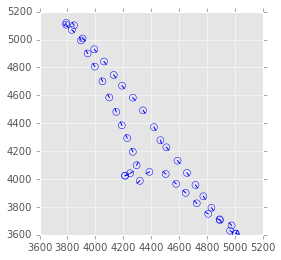

In [98]:
import time
sensor = mcl.laser_sensor()
particle = mcl.robot_particle(global_map, sensor)
locations = np.array([particle.sample_motion(msg)
                      for msg in logdata.values])
location_subset = locations[::50]
fig, ax = plt.subplots()
#ax.scatter(location_subset[:,0], location_subset[:,1], s=200, marker='o',
#            facecolors='none', edgecolors='b')
for pose in location_subset[:, 0:4]:
    mcl.plot_particle(pose, ax, pass_pose=True)
ax.set_aspect('equal')
plt.show()

## Initialize valid particles uniformly on map

Particles are initialized uniformy over the entire 8000cm x 8000cm area with random heading, but are re-sampled if they end up in a grid cell which is not clear with high confidence (map value > 0.8).

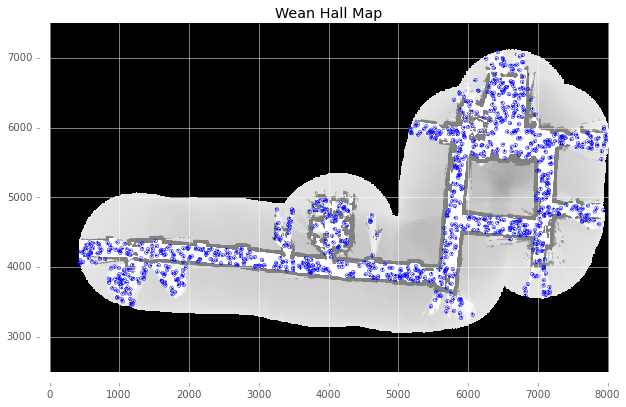

In [15]:
particle_list = [mcl.robot_particle(global_map, sensor)
                 for _ in range(1000)]
mcl.draw_map_state(global_map, particle_list, rotate=True)
plt.show()

## Animation of moving particle

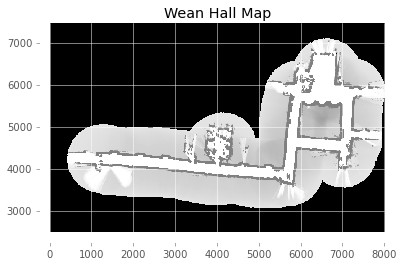

In [29]:
import matplotlib.animation as animation

sensor = mcl.laser_sensor()
particle = mcl.robot_particle(global_map, sensor)
fig, ax = plt.subplots()

def init():    
    mcl.draw_map_state(global_map, ax=ax)

def animate(message):
    #plt.cla()
    #mcl.draw_map_state(global_map, ax=ax)
    particle.sample_motion(message)
    mcl.plot_particle(particle, ax)

ani = animation.FuncAnimation(fig, animate, logdata.values[::50], init_func=init,
    interval=50, blit=False, repeat=False)

plt.show()

## Simple raycast in map

c:\Anaconda3\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


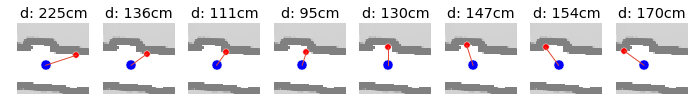

In [271]:
theta = 0
global_map = mcl.occupancy_map('data/map/wean.dat.gz')
fig, axes = plt.subplots(ncols=8, figsize=(12,4))
for ax in axes: 
    theta += np.pi/10
    x,y,dist = mcl.raycast_bresenham(2200, 4200, theta, global_map)
    ax = mcl.draw_map_state(global_map, ax=ax)
    ax.set_title("d: " + str(int(dist)) + 'cm')
    ax.set_ylim((4000,4500))
    ax.set_xlim((2000,2500))
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    ax.scatter(2200, 4200, s=100)
    ax.plot([x, 2200],[y,4200], c='r')
    ax.scatter(x,y, s=40, c='r')

In [272]:
%%timeit
for theta in np.linspace(0,2*np.pi, num=180):
    x,y,dist = mcl.raycast_bresenham(2200, 4200, theta, global_map)

10 loops, best of 3: 30.8 ms per loop


In [273]:
0.035 * 800 * 800 / 60

373.33333333333337

In [274]:
%%timeit
for theta in np.linspace(0,2*np.pi, num=90):
    x,y,dist = mcl.raycast_bresenham(2200, 4200, theta, global_map)

100 loops, best of 3: 15.1 ms per loop


In [ ]:
coord_list = [(xidx, yidx) for yidx in range(800) for xidx in range(800)]
range_array = np.zeros([800,800,8])
for xidx,yidx in coord_list:
    for idx, theta in enumerate(np.linspace(0,2*np.pi, num=8)):
        _,_,dist = mcl.raycast_bresenham(xidx*10, yidx*10, theta, global_map)
        range_array[xidx,yidx,idx] = dist


In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(range_array[:,:,0].T, cmap=plt.cm.gray, interpolation='nearest',
              origin='lower', extent=(0,8000,0,8000), aspect='equal')
ax.set_ylim(2500,7500)
ax.set_xlim(0,8000)